```{include} ../math-definitions.md
```

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Modelo ARIMA estacional

En un modelo ARIMA estacional, términos AR y MA predicen $ y_{t} $ usando valores de datos y errores con rezagos  que son múltiplos de $s$

Por ejemplo, con datos trimestrales (s=4),

-  un modelo autorregresivo estacional de primer orden usa $y_{t-4}$ para predecir $y_{t}$, mientras que uno de segundo orden usa $y_{t-4}, y_{t-8}$ para ello.
-  un modelo de media móvil estacional de primer orden usa $\epsilon_{t-4}$ para predecir $y_{t}$, mientras que uno de segundo orden utiliza $\epsilon_{t-4}, \epsilon_{t-8}$.


Por ejemplo, si quisiéramos pronosticar el número de pasajeros extranjeros que viajarán por el SJO en agosto 2020, tiene mucho sentido modelar ese valor en función del número de pasajeros extranjeros que viajaron por SJO en agosto de años anteriores.

In [2]:
# read data from previous example

sjodatos =pd.read_pickle("https://github.com/randall-romero/econometria/raw/master/data/SJO-pasajeros.pickle")
sjodatoscuadro = sjodatos.unstack()
sjodatoscuadro['extranjeros'].round(1)

,1,2,3,4,5,6,7,8,9,10,11,12
2011,116.3,105.4,128.9,103.1,82.7,88.0,103.3,102.9,64.6,62.6,77.5,90.3
2012,115.8,108.1,130.9,106.0,82.2,89.1,105.9,105.7,67.8,60.4,79.3,92.4
2013,122.9,109.6,133.0,108.5,85.3,95.0,110.3,112.8,70.0,67.3,83.5,107.7
2014,132.3,120.9,146.3,111.9,93.1,96.4,111.4,116.8,71.7,67.3,85.3,104.9
2015,137.2,122.7,143.8,122.8,96.5,105.1,121.5,129.9,79.6,76.4,100.5,122.6
2016,149.2,141.8,161.3,132.0,108.1,113.3,134.6,138.7,84.5,83.2,102.4,124.2
2017,153.6,145.1,179.0,148.7,119.4,126.8,141.0,142.8,97.9,90.2,117.1,135.0
2018,165.7,161.1,189.4,161.3,127.4,134.1,148.9,156.0,100.3,93.9,120.4,140.7
2019,185.3,170.4,206.7,157.0,128.2,137.0,151.4,156.4,101.2,102.0,122.1,153.3


## Un modelo estacional puro

| Año  | May             | Jun             | Jul             | Ago              |
| ---: | --------------: | --------------: | --------------: | ---------------: |
| 2016 |                 |                 |                 | $y_{t-36}=138.7$ |
| 2017 |                 |                 |                 | $y_{t-24}=142.8$ |
| 2018 |                 |                 |                 | $y_{t-12}=156.0$ |
| 2019 | $y_{t-3}=128.2$ | $y_{t-2}=137.0$ | $y_{t-1}=151.4$ | $y_{t}=156.4$    |

En general, un modelo puramente estacional puede representarse por
\begin{multline*}
y_t = \varphi_1y_{t-s} + \varphi_2y_{t-2s} + \dots+ \varphi_Py_{t-Ps} +\\
+ \varepsilon_t + \vartheta_{1}\varepsilon_{t-s} + \vartheta_{2}\varepsilon_{t-2s} + \dots + \vartheta_{Q}\varepsilon_{t-Qs}
\end{multline*}

o bien, en términos de polinomios de rezagos
\begin{equation*}
\notationbrace{\left(1 - \varphi_1\Lag^{s} - \dots - \varphi_P\Lag^{Ps} \right)}{$\varPhi(\Lag^s)$}y_{t} = \notationbrace{\left(1 + \vartheta_{1}\Lag^{s}+\dots+\vartheta_{Q}\Lag^{Qs}\right)}{$\varTheta(\Lag^s)$}\varepsilon_{t}
\end{equation*}


## Diferenciación estacional

La diferenciación estacional se define como la diferencia entre un valor $ y_{t} $ y un valor rezagado un múltiplo de $s$ períodos.
\begin{equation*}
\Delta_{s} y_{t} = \left(1-\Lag^{s}\right)y_t = y_t - y_{t-s}
\end{equation*}

Por ejemplo:
trimestral
:   $\Delta_{4} y_{t} = \left(1-\Lag^{4}\right)y_t = y_t - y_{t-4}$

mensual
:   $\Delta_{12} y_{t} = \left(1-\Lag^{12}\right)y_t = y_t - y_{t-12}$


Nótese que siguiendo esta notación $ \Delta y_t = \Delta_1 y_t $. Pero
```{warning}
\begin{align*}
              \Delta_2 y_t &\neq \Delta^2 y_t \\
\left(1 - \Lag^2\right)y_t &\neq \left(1-\Lag\right)^2y_t \\
\left(1 - \Lag^2\right)y_t &\neq \left(1-2\Lag + \Lag^2\right)y_t \\
              y_t- y_{t-2} &\neq y_t - 2y_{t-1} + y_{t-2}
\end{align*}
```

## Un modelo ARIMA para observaciones de la misma estación

En general, podríamos plantear un modelo ARIMA para observaciones de una sola estación (mes, trimestre)
\begin{equation*}
\varPhi(\Lag^s)\Delta_s^D y_t = \varTheta(\Lag^s)\varepsilon_{t}
\end{equation*}

Es usualmente razonable asumir que esta misma relación la cumplen las observaciones de la estación anterior
\begin{equation*}
\varPhi(\Lag^s)\Delta_s^D y_{t-1} = \varTheta(\Lag^s)\varepsilon_{t-1}
\end{equation*}

En general, los errores de estas relaciones $\varepsilon_{t}, \varepsilon_{t-1}$ podrían estar correlacionadas, por lo que en principio podemos plantear el modelo ARIMA:
\begin{equation*}
\Phi(\Lag)\Delta^d \varepsilon_{t} = \Theta(\Lag)\epsilon_{t}
\end{equation*}
donde $\epsilon_{t}$ es ruido blanco.


## El modelo SARIMA

Asumiendo que el proceso ARIMA de cada estación es invertible obtenemos
\begin{align*}
     \varPhi(\Lag^s)\Delta_s^D y_t &= \varTheta(\Lag^s)\varepsilon_{t}\\
\varTheta^{-1}(\Lag^s)\varPhi(\Lag^s)\Delta_s^D y_t &= \varepsilon_{t}\\
\Phi(\Lag)\Delta^d\varTheta^{-1}(\Lag^s)\varPhi(\Lag^s)\Delta_s^D y_t &= \Phi(\Lag)\Delta^d\varepsilon_{t}\\
                    &= \Theta(\Lag)\epsilon_{t} \\
\notation{\Phi(\Lag)}{$p$}\notation{\varPhi(\Lag^s)}{$P$}\notation{\Delta^d_{\phantom{D}}}{$d$}\notation{\Delta_s^D}{$D$} y_t &= \notation{\Theta(\Lag)}{$q$}\notation{\varTheta(\Lag^s)}{$Q$}\epsilon_{t}
\end{align*}

Este modelo se denomina $\alert{\text{SARIMA}(p,d,q)\times(P,D,Q)_s}$.



{{ empieza_ejemplo }} Algunos modelos SARIMA {{ fin_titulo_ejemplo }}

- $\text{SARIMA}(0,0,0)\times(0,1,0)_4 = \text{SARIMA}(0,1,0)_4$
\begin{align*}
\Delta_4 y_t &= \epsilon_{t} \\
(1-\Lag^4) y_t &= \epsilon_{t} \\
y_{t} - y_{t-4} &= \epsilon_{t}
\end{align*}

- $\text{SARIMA}(2,0,0)_4 = \text{SAR}(2)_4$
\begin{align*}
\left(1-\varphi_1\Lag^4-\varphi_2\Lag^8\right) y_t &= \epsilon_{t} \\
y_{t} - \varphi_1y_{t-4} - \varphi_2y_{t-8} &= \epsilon_{t}
\end{align*}

- $\text{SARIMA}(0,0,3)_4 = \text{SMA}(3)_4$
\begin{align*}
y_t &= (1+\vartheta_1\Lag^4 +\vartheta_2\Lag^8 + \vartheta_3\Lag^{12})\epsilon_{t} \\
    &= \epsilon_{t} + \vartheta_1\epsilon_{t-4} +\vartheta_2\epsilon_{t-8} + \vartheta_3\epsilon_{t-12}
\end{align*}

- $\text{SARIMA}(0,1,1)\times(0,1,1)_4$
\begin{align*}
\Delta \Delta_4 y_t &= (1+\theta\Lag)(1+\vartheta\Lag^4 )\epsilon_{t} \\
(1-\Lag)(1-\Lag^4) y_t &= (1+\theta\Lag)(1+\vartheta\Lag^4 )\epsilon_{t} \\
(1-\Lag -\Lag^4 + \Lag^5) y_t &= (1+\theta\Lag +\vartheta\Lag^4 +\theta\vartheta\Lag^5)\epsilon_{t} \\
y_{t} - y_{t-1} - y_{t-4} + y_{t-5} &= \epsilon_{t} + \theta\epsilon_{t-1} + \vartheta\epsilon_{t-4} + \theta\vartheta\epsilon_{t-5}
\end{align*}

- $\text{SARIMA}(1,0,0)\times(0,1,1)_4$
\begin{align*}
(1-\phi\Lag) \Delta_4 y_t &= (1+\vartheta\Lag^4 )\epsilon_{t} \\
(1-\phi\Lag)(1-\Lag^4) y_t &= (1+\vartheta\Lag^4 )\epsilon_{t} \\
(1-\phi\Lag -\Lag^4 + \phi\Lag^5) y_t &= (1+\vartheta\Lag^4 )\epsilon_{t} \\
y_{t} - \phi y_{t-1} - y_{t-4} + \phi y_{t-5} &= \epsilon_{t} + \vartheta\epsilon_{t-4}
\end{align*}

{{ termina_ejemplo }}


## Identificación de un modelo SARIMA

La identificación de modelos estacionales es más difícil que la identificación de modelos no estacionales por dos razones:

1. Muchas series estacionales exhiben también patrones no estacionales y por lo tanto las FAC y las FACP estimadas contienen ambos patrones.
2. No hay muchas correlaciones en valores $k$ múltiplos de $s$. Por ejemplo, en una serie mensual podríamos contar únicamente con $k = 12$, $k = 24$ y $k = 36$

En la práctica, cuando se tienen dudas, se utilizan herramientas que automatizan esta selección de parámetros a partir de criterios de selección.



{{ empieza_ejemplo }} Estimación de un modelo SARIMA {{ fin_titulo_ejemplo }}

El correlograma de la serie de movimientos de pasajeros extranjeros en SJO sugiere que la serie tiene un componente estacional.

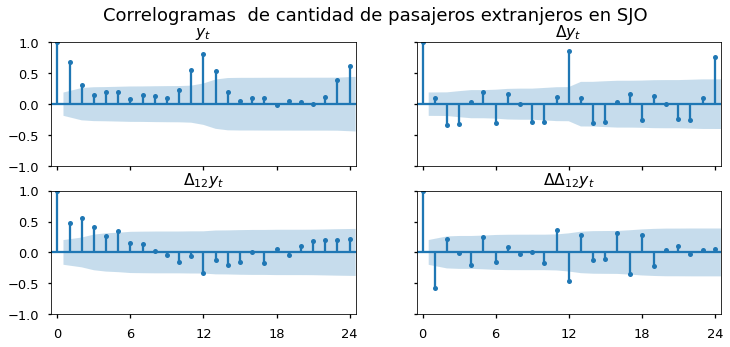

In [3]:
def correlogramas4(serie, residencia, func):
    fig, axs= plt.subplots(2,2, figsize=[12,5], sharex=True, sharey=True)
    opts = dict(lags=24)
    if func is plot_pacf:
        opts['method'] = 'ols'

    func(serie, **opts,ax=axs[0,0], title='$y_t$');
    func(serie.diff(1).dropna(), **opts, ax=axs[0,1],title='$\Delta y_t$');
    func(serie.diff(12).dropna(), **opts, ax=axs[1,0],title='$\Delta_{12}y_t$');
    func(serie.diff(1).diff(12).dropna(), **opts, ax=axs[1,1],title='$\Delta\Delta_{12}y_t$');

    for ax in axs.flat:
        ax.set(xlim=[-0.5,24.5], xticks=np.arange(0,25,6))

    pp = 'parcial' if (func is plot_pacf) else ''
    fig.suptitle(f'Correlogramas {pp} de cantidad de pasajeros {residencia} en SJO', size=18)
    return fig

extranjeros = pd.DataFrame(np.log(sjodatos['extranjeros'].values), index=pd.period_range('2011-01', '2019-12', freq='M'))
correlogramas4(extranjeros, 'extranjeros', plot_acf);

Al usar una herramienta de selección de modelos `statsmodels.tsa.x13.x13_arima_select_order` en Python se selecciona el modelo $\text{SARIMA}(0, 1, 1)\times(0, 1, 1)_{12}$.

In [4]:
mod_extranjeros = SARIMAX(extranjeros, order=(0,1,1), seasonal_order=(0,1,1,12)).fit()
mod_extranjeros.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  0   No. Observations:                  108
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 194.101
Date:                            Thu, 21 Jul 2022   AIC                           -382.202
Time:                                    00:05:34   BIC                           -374.540
Sample:                                01-31-2011   HQIC                          -379.106
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6109      0.087     -7.024      0.000      -0.781      -0.440
ma.S.L12      -0.7632      0.117     -6.520      0.000      -0.993      -0.534
sigma2         0.0009      0.000      6.349      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 0.23
Prob(Q):                              0.83   Prob(JB):                         0.89
Heteroskedasticity (H):               1.56   Skew:                             0.09
Prob(H) (two-sided):                  0.21   Kurtosis:                         3.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

El modelo estimado es
\begin{align*}
(1-\Lag)(1-\Lag^{12}) y_t &= (1-0.611\Lag)(1-0.765\Lag^{12} )\epsilon_{t} \\
y_{t} - y_{t-1} - y_{t-12} + y_{t-13} &= \epsilon_{t} - 0.611\epsilon_{t-1} -0.765\epsilon_{t-12} + 0.467\epsilon_{t-13}
\end{align*}

Los resultados de la tabla anterior muestran que:

- Los coeficiente estimados son significativos.
- Los residuos del modelo...
  - parecen no estar autocorrelacionados: el valor $p$ del estadístico $Q$ de Lung-Box es 0.19.
  - parecen ser normales: la asimetría es 0.09, la kurtosis es 3.16, y el valor $p$ de la prueba de Jarque-Bera es 0.89.

Por ello, podemos pensar que el modelo estimado es una buena representación de los datos.



La expresión
\begin{equation*}
y_{t} = y_{t-1} + y_{t-12} - y_{t-13} + \epsilon_{t} - 0.611\epsilon_{t-1} -0.765\epsilon_{t-4} + 0.467\epsilon_{t-5}
\end{equation*}
puede utilizarse recursivamente para generar pronósticos.

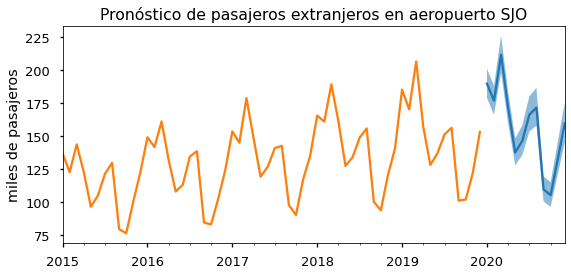

In [5]:
def plot_forecast(modelo, serie, residencia, ax):
    fcast = modelo.get_forecast('2020-12')
    ci = np.exp(fcast.conf_int())
    np.exp(fcast.predicted_mean).plot(ax=ax)
    ax.fill_between(ci.index,'lower y', 'upper y', data=ci, alpha=0.5)    
    np.exp(serie).plot(ax=ax, legend=False)
    ax.set(title=f'Pronóstico de pasajeros {residencia} en aeropuerto SJO')
    return ax

fig, ax = plt.subplots(1,1, figsize=[9,4])
plot_forecast(mod_extranjeros, extranjeros['2015':], 'extranjeros', ax)
ax.set(ylabel='miles de pasajeros');

{{ termina_ejemplo }}



## Pronosticando un modelo SARIMA

Si expandimos los polinomios del proceso $\text{SARIMA}(p,d,q)\times(P,D,Q)_s$
\begin{equation*}
\notation{\Phi(\Lag)}{$p$}\notation{\varPhi(\Lag^s)}{$P$}\notation{\Delta^d_{\phantom{D}}}{$d$}\notation{\Delta_s^D}{$D$} y_t = \notation{\Theta(\Lag)}{$q$}\notation{\varTheta(\Lag^s)}{$Q$}\epsilon_{t}
\end{equation*}

el resultado será un polinomio de grado $p+Ps+d+D$ del lado izquierdo y uno de grado $q+Qs$ del lado derecho.

Para horizontes de más allá de $q+Qs$ períodos, la dinámica de estos pronósticos estará gobernada únicamente por la ecuación en diferencia homogénea
\begin{equation*}
\Phi(\Lag)\varPhi(\Lag^s)\Delta^d\Delta_s^D \hat{y}_{t+h} = 0
\end{equation*}


![sarima-forecast-paterns](figures/sarima-forecast-patterns.png)